# Data Review and Preprocessing

In [45]:
import numpy as np
import matplotlib.pyplot as plt

import ztf # shared scritp where the util functions are stored

labeltocode = ztf.class_code
print(labeltocode)
codetolabel = dict()

for k, v in labeltocode.items():
    if v == -1:
        codetolabel[v] = 'Discarded'
    else:
        codetolabel[v] = k
%load_ext autoreload
%autoreload 2

{'AGN': 0, 'Blazar': 1, 'CV/Nova': 2, 'Ceph': 3, 'DSCT': 4, 'EA': 5, 'EB/EW': 5, 'LPV': 6, 'NLAGN': -1, 'NLQSO': -1, 'Periodic-Other': 7, 'QSO': 8, 'RRL': 9, 'RSCVn': -1, 'SLSN': 10, 'SNII': 11, 'SNIIb': 11, 'SNIIn': 11, 'SNIa': 12, 'SNIbc': 13, 'TDE': -1, 'YSO': 14, 'ZZ': -1}
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Getting lightcurves 

In [2]:
path_meta = './data/raw_data/ztf/dfcrossmatches_ZTF_prioritized_v8.0.1.csv'
path_dete = './data/raw_data/ztf/detections_v8.csv'

In [3]:
%%time
use_chunks = False # ~15min and 7.52 GB RAM using chunks - ~4min and 32.6 GB RAM else
lightcurves, labels, oids = ztf.get_light_curves(path_meta, path_dete, chunks=False)

CPU times: user 4min 40s, sys: 29.3 s, total: 5min 9s
Wall time: 5min 9s


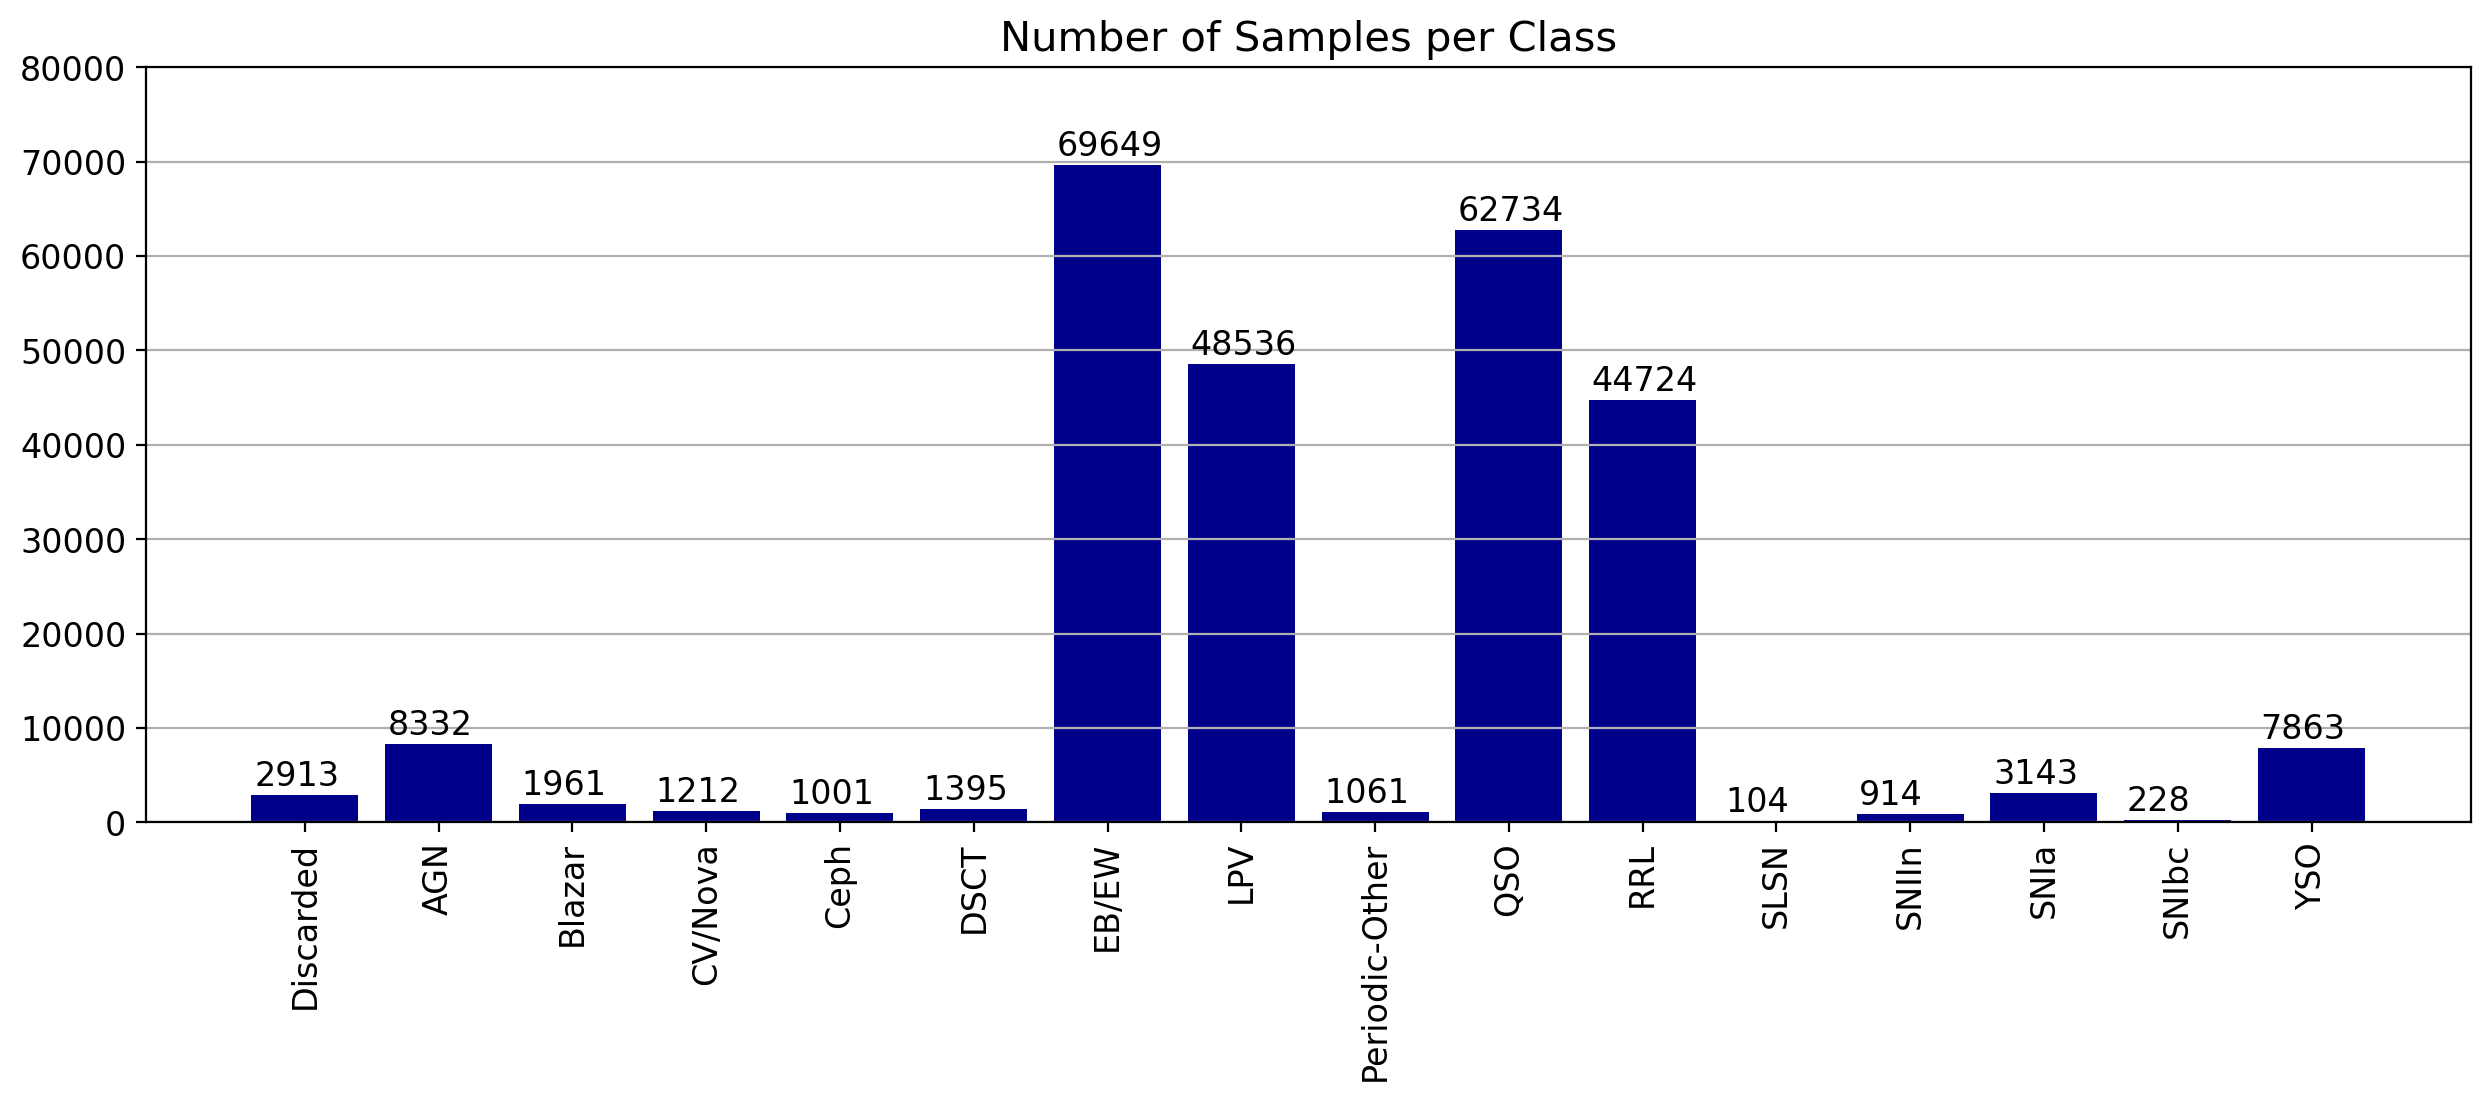

In [4]:
uniques, counts = np.unique(labels, return_counts=True)

LABELS = [codetolabel[u] for u in uniques]
plt.figure(figsize=(15,5), dpi=200)
plt.bar(uniques, counts, align='center', color='darkblue')

for u, c in zip(uniques, counts):
    plt.text(u-0.38, c+1000, '{}'.format(c), fontsize=12)

plt.xticks(uniques, LABELS, rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Number of Samples per Class', fontsize=15)
plt.grid(axis='y')
plt.ylim(0, 80000)
plt.show()

# ALeRCE filter

In [5]:
from joblib import Parallel, delayed
import multiprocessing as mp
n_jobs = mp.cpu_count()

In [6]:
def alerce_filter(sample, band=1, rb_lower_bound=0.55, obserr_upper_bound=1):
    sample = sample[np.array(sample[:, -1], dtype=bool)]
    sample = sample[sample[:, -2]>=rb_lower_bound]
    sample = sample[sample[:, 2]<obserr_upper_bound]
    sample = sample[sample[:, -3] == band]
    sample = sample[:, :-3]
    
    return sample

In [7]:
%%time
result = Parallel(n_jobs=n_jobs, backend='multiprocessing')(delayed(alerce_filter)(sample) \
                                                            for sample in lightcurves)

CPU times: user 24.7 s, sys: 5.53 s, total: 30.2 s
Wall time: 30.2 s


In [8]:
print(len(result), len(labels))

255770 255770


# Filter by min. number of observations

In [9]:
len_lower_bound = 10
indices = [i for i, r in enumerate(result) if r.shape[0]>=len_lower_bound]

lics_a = np.array(result, dtype=object)[indices]
labs_a = np.array(labels, dtype=object)[indices]
oids_a = np.array(oids, dtype=object)[indices]

In [10]:
print(len(lics_a), len(labs_a), len(oids_a))

138648 138648 138648


# Getting out -1 labels

In [11]:
indices = [i for i, r in enumerate(labs_a) if r != -1]

lics_b = np.array(lics_a, dtype=object)[indices]
labs_b = np.array(labs_a, dtype=object)[indices]
oids_b = np.array(oids_a, dtype=object)[indices]

In [12]:
print(len(lics_b), len(labs_b), len(oids_b))

138033 138033 138033


### Train, validation and test split

In [13]:
import pandas as pd
partial = pd.DataFrame(np.vstack([range(len(labs_b)), labs_b, oids_b]).T, 
                       columns = ['index', 'label', 'oid'])
partial.head()

,index,label,oid
0,0,5,ZTF17aaaaact
1,1,6,ZTF17aaaaahl
2,2,6,ZTF17aaaaajz
3,3,6,ZTF17aaaaaly
4,4,6,ZTF17aaaaasi


In [14]:
label_groups = partial.groupby('label')
train_frac = 0.5
val_frac = 0.25 # 0.25 for testing


train_df = []
val_df   = []
test_df  = []
for lab, subframe in label_groups:
    # Shuffle
    subframe = subframe.sample(frac=1)
    
    n_train = int(subframe.shape[0] * train_frac)
    n_val = int(subframe.shape[0] * val_frac)
    
    train_frame = subframe.iloc[:n_train, :]
    val_frame   = subframe.iloc[n_train:n_train+n_val, :]
    test_frame  = subframe.iloc[n_train+n_val:, :]
    
    train_df.append(train_frame)
    val_df.append(val_frame)
    test_df.append(test_frame)

train_df = pd.concat(train_df, 0)
val_df   = pd.concat(val_df, 0)
test_df  = pd.concat(test_df, 0)

print('train: {}\nval: {}\ntest:{}'.format(train_df.shape, val_df.shape, test_df.shape))


train: (69013, 3)
val: (34503, 3)
test:(34517, 3)


/tmp/ipykernel_13739/3734568282.py:24: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  train_df = pd.concat(train_df, 0)
/tmp/ipykernel_13739/3734568282.py:25: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  val_df   = pd.concat(val_df, 0)
/tmp/ipykernel_13739/3734568282.py:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  test_df  = pd.concat(test_df, 0)


In [15]:
subsets = {'train':dict(), 'validation':dict(), 'test':dict()}
subsets['train']['x'] = lics_b[train_df.index]
subsets['train']['y'] = labs_b[train_df.index]
subsets['train']['oid'] = oids_b[train_df.index]

subsets['validation']['x'] = lics_b[val_df.index]
subsets['validation']['y'] = labs_b[val_df.index]
subsets['validation']['oid'] = oids_b[val_df.index]

subsets['test']['x'] = lics_b[test_df.index]
subsets['test']['y'] = labs_b[test_df.index]
subsets['test']['oid'] = oids_b[test_df.index]

In [16]:
print('TRAIN: {} - {}\nVAL: {} - {}\nTEST:{} - {}'.format(
                                         subsets['train']['x'].shape, subsets['train']['y'].shape,
                                         subsets['validation']['x'].shape, subsets['validation']['y'].shape,
                                         subsets['test']['x'].shape, subsets['test']['y'].shape))

TRAIN: (69013,) - (69013,)
VAL: (34503,) - (34503,)
TEST:(34517,) - (34517,)


### Padding Light Curves

In [47]:
%%time
X_train, y_train, m_train, o_train = ztf.pad_lightcurves(subsets['train']['x'], 
                                                         subsets['train']['y'], 
                                                         subsets['test']['oid']
                                                         maxobs=200)
X_valid, y_valid, m_valid, o_valid = ztf.pad_lightcurves(subsets['validation']['x'], 
                                                         subsets['validation']['y'], 
                                                         subsets['test']['oid'],
                                                         maxobs=200)

SyntaxError: invalid syntax (<unknown>, line 4)

In [18]:
%%time
maxobs_testing = np.max([x.shape[0] for x in subsets['test']['x']])
X_test, y_test, m_test = ztf.pad_lightcurves(subsets['test']['x'], subsets['test']['y'], 
                                             maxobs=maxobs_testing)

CPU times: user 2.84 s, sys: 811 ms, total: 3.65 s
Wall time: 3.65 s


In [19]:
print('TRAIN: {}  - {}\nVALID: {}  - {}\nTEST:  {} - {}'.format(X_train.shape, y_train.shape,
                                                          X_valid.shape, y_valid.shape,
                                                          X_test.shape, y_test.shape))

TRAIN: (71625, 200, 3)  - (71625,)
VALID: (35859, 200, 3)  - (35859,)
TEST:  (34518, 920, 3) - (34518,)


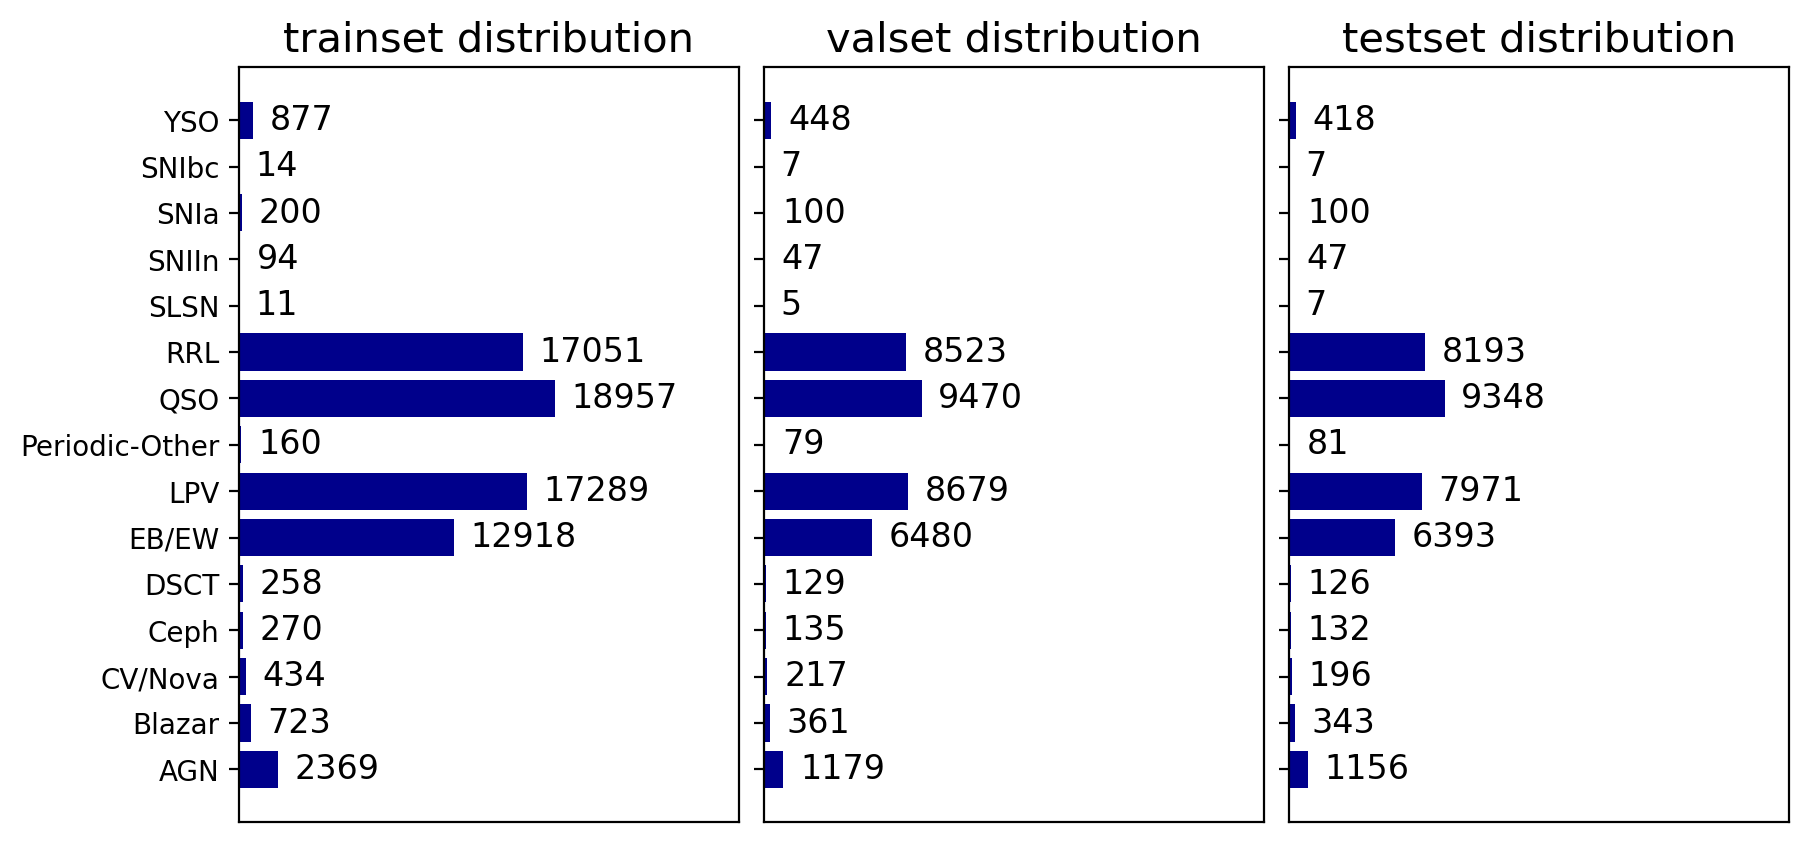

In [20]:
fig, axes = plt.subplots(1, 3, dpi=200, figsize=(10,5),sharey=True, 
                        gridspec_kw={'hspace': 0., 'wspace': 0.05},)

for i, (labs, name) in enumerate(zip([y_train, y_valid, y_test], ['train', 'val', 'test'])):
    
    uniques, counts = np.unique(labs, return_counts=True)

    LABELS = [codetolabel[u] for u in uniques]

    axes[i].barh(uniques, counts, align='center', color='darkblue')

    for u, c in zip(uniques, counts):
        axes[i].text(c+1000, u-0.2, '{}'.format(c), fontsize=12)
    
    x_ticks = range(len(uniques))
    axes[i].set_yticks(x_ticks)
    axes[i].set_yticklabels(LABELS)

    axes[i].set_title('{}set distribution'.format(name), fontsize=15)
    axes[i].set_xticks([])
    axes[i].set_xlim(0, 30000)
    
plt.show()

### Writting Records

In [35]:
from data import create_record
from data import load_record

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
create_record(light_curves=X_train, 
              labels=y_train, 
              masks=m_train, 
              oids=oids, 
              path='./data/records/train')

In [37]:
create_record(light_curves=X_valid, 
              labels=y_valid, 
              masks=m_valid, 
              oids=oids, 
              path='./data/records/val')

In [ ]:
create_record(light_curves=X_test, 
              labels=y_test, 
              masks=m_test, 
              oids=oids, 
              path='./data/records/train')

In [36]:
dataset = load_record('./data/records/train', batch_size=10)

NameError: in user code:

    /home/ubuntu/2PhaseOrNot2Phase/data.py:121 None  *
        lambda x: read_tfrecord(x)

    NameError: name 'read_tfrecord' is not defined
